# Movie Review Sentiments by Matthew Inglis-Whalen [2023]

A common use-case for Natural Language Processing is to determine the sentiment of a text submission. In this notebook we train a bag-of-words model to predict whether or not a given movie review is positive or negative. For example, words like "bad" and "worst" in a review are correlated with a low rating for the movie, while words like "great" and "excellent" are correlated with a good rating. The model uses 1- and 2-gram token sizes, but is still easily fooled. A short and simple review like "Not great." will result in a positive sentiment prediction with a 95.3% prediction probability. Nevertheless, among the reviews in the withheld test set, this simple bag-of-words model achieves an accuracy of 91%.

In [1]:
USE_PREMADE = True

# standard imports
import numpy as np
import pandas as pd

# utility
from time import perf_counter

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

# saving model
import pickle as pkl
from asizeof import asizeof as better_sizeof  # check vectorizer and model are small enough (<100MB) for AWS micro (500-700MB memory)

from scipy.sparse._csr import csr_matrix

## Data Import and Cleaning

Let's import and examine the first few rows of data

In [2]:
data_path = "../data/IMDB_Dataset.csv"

reviews_raw = pd.read_csv(data_path)
reviews_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


The sentiment is coded as a string, so I'll turn it into an int

In [3]:
def sentiment_to_int(s : str) -> int:
    if s == "positive" :
        return 1
    return 0

reviews = reviews_raw['review']
ratings = reviews_raw['sentiment'].map(sentiment_to_int)

print(reviews[3])
print(ratings[3])

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.
0


## Model genesis

We use a Hashing VEctorizer rather than a TfidfVectorier because of memory constraints on the server. This is essentially a CountVectorizer (the bag-of-words) which condenses a document down to a dictionary of word occurences, followed by a TfidfTransformer (Term Frequency * Inverse Document Frequency) to normalize the dictionary so that document length has no influence on predictions. The frequency can contain negative values (a byproduct of the hashing algorithm) so interpretation of model weights needs extra work.

In [4]:
from sklearn.feature_extraction.text import HashingVectorizer

tokens_to_exclude = ["br","the","a","is","of","and","it","to","would","your","which","so","this",
                     "was","ll","on","or","for","with","as","me","that","in","be","but","could",
                     "its","em","has","then","were","where","who","thats"]

vectorizer = HashingVectorizer( ngram_range=(1,2), stop_words = tokens_to_exclude, n_features = 2**18, strip_accents='ascii', norm='l2' )

print(f"{better_sizeof(vectorizer)/1e3:.1f}KB")

4.1KB


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

transformed_X = vectorizer.fit_transform(reviews)

X_train, X_test, y_train, y_test = train_test_split(transformed_X, ratings, test_size=0.2, random_state=2023)

In [6]:
print(transformed_X)
print(transformed_X[0,1085])

  (0, 1085)	0.04512936824065242
  (0, 1130)	0.04512936824065242
  (0, 1428)	-0.04512936824065242
  (0, 1596)	-0.04512936824065242
  (0, 1907)	-0.04512936824065242
  (0, 3642)	-0.04512936824065242
  (0, 3699)	0.04512936824065242
  (0, 4256)	0.04512936824065242
  (0, 5230)	-0.04512936824065242
  (0, 5770)	-0.04512936824065242
  (0, 5983)	0.09025873648130484
  (0, 7074)	0.04512936824065242
  (0, 7146)	-0.04512936824065242
  (0, 7528)	0.04512936824065242
  (0, 7615)	-0.04512936824065242
  (0, 8842)	0.04512936824065242
  (0, 9492)	0.04512936824065242
  (0, 9584)	-0.04512936824065242
  (0, 9653)	-0.04512936824065242
  (0, 9695)	0.04512936824065242
  (0, 12793)	0.04512936824065242
  (0, 13170)	-0.04512936824065242
  (0, 13335)	-0.04512936824065242
  (0, 13539)	-0.04512936824065242
  (0, 15381)	0.04512936824065242
  :	:
  (49999, 216296)	-0.06884283908215143
  (49999, 216967)	0.06884283908215143
  (49999, 218545)	0.06884283908215143
  (49999, 219007)	-0.06884283908215143
  (49999, 219482)	0.06

In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=5000)

logreg_grid = {
    'penalty' : ['l2'],
    'C' : [5, 10, 20]
}
logreg_grid_quick = {
    'penalty': ['l2'],
    'C': [10]
}

In [8]:
# runtime is 165 seconds on my machine
t0 = perf_counter()

if USE_PREMADE :
    with open('sentiment_inference_model_hashed.pkl', 'rb') as f_m :
        best_model = pkl.load(f_m)
else :
    search_cv = GridSearchCV(estimator=logreg, 
                             param_grid=logreg_grid_quick,
                             scoring='accuracy',
                             cv=5)
    search_cv.fit(X_train,y_train)
    
    best_model = search_cv.best_estimator_
    best_hypers = search_cv.best_params_
    avg_score = search_cv.best_score_
    
    print(f"Best logistic regression model achieves an average accuracy of {avg_score:.2F} with args {best_hypers}")
    
t1 = perf_counter()
print(f"Ran in {t1-t0:.1f} seconds")

Ran in 0.0 seconds


## Model interpretation

Using the hashing vectorizer makes it difficult to interpret the coefficients of the logistic regression. Here we'll use another vectorizer with a vocabulary to find the most-often used words, then we'll interpret the model's preference for the top 50 words.

In [9]:
def decode_document_bag(sp_arr : csr_matrix, vocab_list : list[str]) -> list[(str, int)] :
    """Turns a sparse array into a list of human-readable tuples"""
    mylist = [(vocab_list[j],sp_arr[i,j]) for i, j in zip(*sp_arr.nonzero())]
    return mylist

def sort_decoded( dec: list[(str,int)] ) -> list[(str, int)] :
    """Sorts a list of decoded (word, count) tuples according to the count"""
    sorted_bag = sorted(dec, key = lambda x: x[1], reverse=True)
    return sorted_bag

def sorted_decoded_bag(sp_arr : csr_matrix, vocab_list : list[str]) -> list[(str, int)] :
    """Decodes and sorts a sparse array"""
    decoded = decode_document_bag(sp_arr,vocab_list)
    sorted_bag = sort_decoded(decoded)
    return sorted_bag

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(ngram_range=(1,2), stop_words = tokens_to_exclude, min_df=10, strip_accents='ascii' ).fit(reviews)
all_bag = cvec.transform(reviews).sum(axis=0)
ordered_keys = cvec.get_feature_names_out()

all_sorted = sorted_decoded_bag(all_bag,ordered_keys)
print(all_sorted[:50])

[('movie', 87963), ('film', 79690), ('you', 69116), ('not', 60730), ('he', 58820), ('are', 58378), ('his', 57553), ('have', 55201), ('one', 53595), ('all', 46938), ('at', 46796), ('they', 45377), ('by', 44478), ('an', 42976), ('from', 40498), ('like', 40166), ('there', 37517), ('just', 35174), ('her', 34798), ('out', 34201), ('about', 34159), ('if', 33986), ('what', 32230), ('some', 31132), ('good', 29753), ('can', 29055), ('when', 28060), ('more', 28011), ('very', 27725), ('she', 27164), ('up', 26389), ('no', 25283), ('time', 25105), ('my', 24909), ('even', 24865), ('only', 23238), ('story', 23117), ('really', 23093), ('see', 23026), ('their', 22750), ('had', 22064), ('we', 21260), ('well', 21254), ('than', 19328), ('much', 19314), ('bad', 18471), ('get', 18420), ('been', 18350), ('other', 18273), ('do', 18224)]


In [11]:
hashdx_word_dict = {}

for pair in all_sorted[:50000] :
    gram = pair[0]
    transformed_gram = vectorizer.transform([gram])
    docdx_as_list, hashed_idx_as_list = transformed_gram.nonzero()
    if hashed_idx_as_list.size > 0 :
        docdx, hashed_idx = docdx_as_list[0], hashed_idx_as_list[0]
        is_positive = transformed_gram[docdx,hashed_idx] > 0
        if hashed_idx not in hashdx_word_dict :
            hashdx_word_dict[hashed_idx] = f"{'+' if is_positive else '-'}{gram}"

print("Done!")

Done!


In [12]:
print(hashdx_word_dict[70406])

-very


In [26]:
# coef_label = [(best_model.coef_[0,i], hashdx_word_dict[i]) 
coef_label = []
for idx in range(len(best_model.coef_[0])) :
    if idx in hashdx_word_dict :
        gram_with_sign = hashdx_word_dict[idx]
        gsign, gram = 1 if gram_with_sign[0] == '+' else -1, gram_with_sign[1:]
        coef_label.append((gsign*best_model.coef_[0,idx], gram ) )

biggest_influences_abs = sorted(coef_label, key = lambda x: abs(x[0]), reverse=True)
print(biggest_influences_abs[:20])
signed_biggest = sorted(biggest_influences_abs[:50], key = lambda x: x[0], reverse=True)
print('\n',biggest_influences[-10:])

biggest_two_words_abs = []
added = 0
for _, (coef, gram) in enumerate(biggest_influences_abs) :
    if added > 49 :
        break
    if len(gram.split()) > 1 :
        biggest_two_words_abs.append((coef, gram))
        added += 1
biggest_two_words = sorted(biggest_two_words_abs[:50], key = lambda x: x[0], reverse=True)

[(-18.76835367098389, 'worst'), (-15.331928156586342, 'awful'), (-12.781858154891422, 'boring'), (11.94260616877307, 'excellent'), (-11.006884160388047, 'terrible'), (-11.000060855516665, 'waste'), (10.688886031030504, 'perfect'), (-10.673980005767156, 'horrible'), (-10.461407743361235, 'disappointment'), (-10.397642801260789, 'poor'), (-10.337789033906516, 'dull'), (10.180859370852845, 'amazing'), (-10.153894594065557, 'poorly'), (9.791860110473094, 'wonderful'), (-9.773965575522443, 'annoying'), (-9.485995646227304, 'fails'), (-9.478164256762968, 'worse'), (-9.251768017216225, 'disappointing'), (-9.176635394142606, 'save'), (9.024599051332775, 'superb')]

 [(0.0003681743136097169, 'darkwolf'), (0.0003437515898195118, 'lone'), (-0.0001366298774347281, 'furniture'), (-0.00013549989533594403, 'other works'), (0.0001197485665142463, 'sabotage'), (-0.00011162658180613714, 'clear they'), (6.641840297669624e-05, 'seen such'), (-5.640527450072541e-05, 'expanding'), (-2.7646025355255655e-05, 

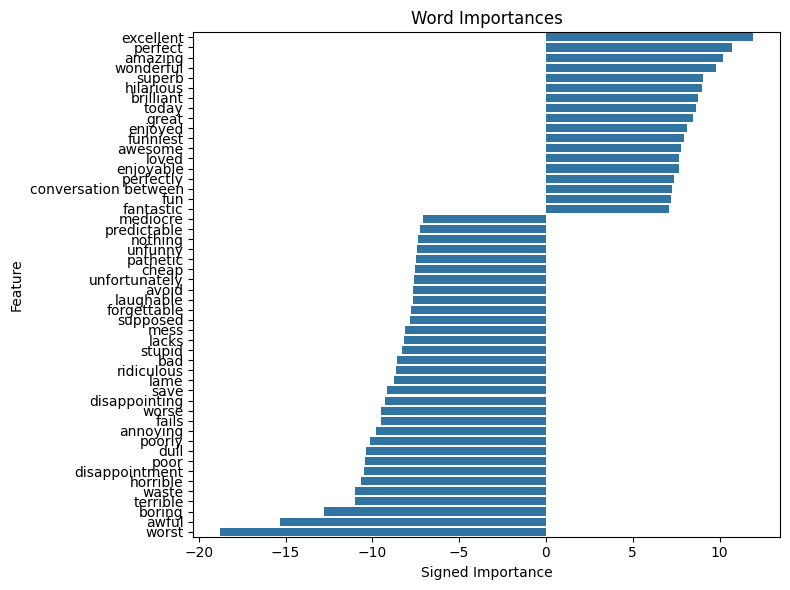

In [27]:
# Interpret the model's fit by looking at the largest-coefficient words
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=[x[0] for x in sorted_biggest], y=[x[1] for x in sorted_biggest], ax=ax)
ax.set_title('Word Importances')
ax.set_xlabel('Signed Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('logistic_importance.png')

plt.show()

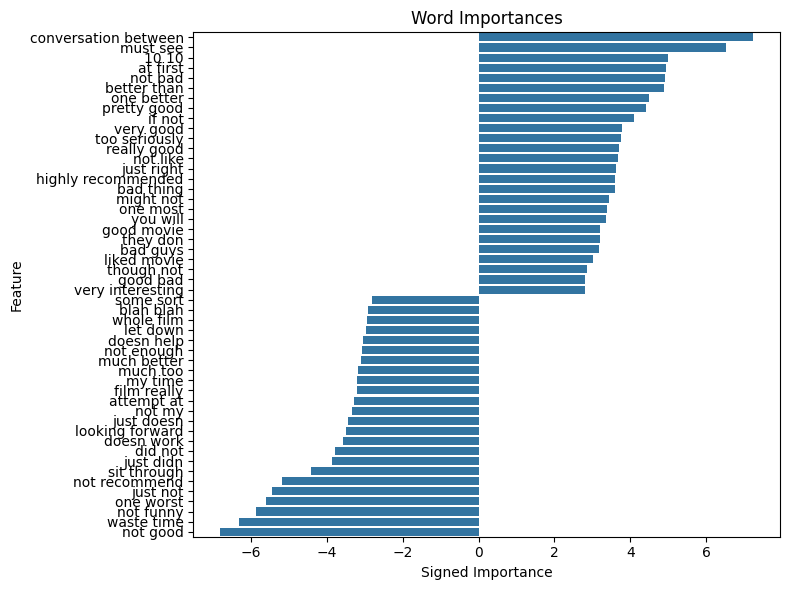

In [28]:
# Interpret the model's fit by looking at the largest-coefficient words
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=[x[0] for x in biggest_two_words], y=[x[1] for x in biggest_two_words], ax=ax)
ax.set_title('Word Importances')
ax.set_xlabel('Signed Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('logistic_importance.png')

plt.show()

In [15]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test,y_pred)
print(f"Test set accuracy: {test_acc}")

Test set accuracy: 0.9065


## Export model and vocabulary

We need to pickle the model and vocabulary in order to deploy the model

In [16]:
# pickle the vectorizer and inference model


with open('vocabulary_hashed.pkl', 'wb') as f_v :
    pkl.dump(vectorizer, f_v)
with open('sentiment_inference_model_hashed.pkl', 'wb') as f_m :
    pkl.dump(best_model, f_m)

In [17]:
# check that the vocabulary and inference model work when de-pickled

with open('vocabulary_hashed.pkl', 'rb') as f_v :
    loaded_vocab = pkl.load(f_v)
with open('sentiment_inference_model_hashed.pkl', 'rb') as f_m :
    loaded_model = pkl.load(f_m)

In [18]:
input_str = """
This was clearly no Tarantino film, but it had a lot of good things going for it. 
I liked the plot, and the visuals were above par. Not bad! Looking forward to more from this director! Not great.
"""

input_str = """
not great. i had a lot of fun though
"""

transformed_input = loaded_vocab.transform([input_str])
input_sentiment = loaded_model.predict_proba(transformed_input)[0,1]
print(transformed_input)
print(input_sentiment)

  (0, 4678)	0.30151134457776363
  (0, 13516)	0.30151134457776363
  (0, 53144)	-0.30151134457776363
  (0, 80236)	0.30151134457776363
  (0, 84380)	0.30151134457776363
  (0, 85639)	0.30151134457776363
  (0, 123878)	-0.30151134457776363
  (0, 139636)	0.30151134457776363
  (0, 163181)	-0.30151134457776363
  (0, 219007)	-0.30151134457776363
  (0, 230609)	-0.30151134457776363
0.9931787940080787


In [19]:
for n, word in enumerate(input_str.split()):
    word_as_sparse_arr = vectorizer.transform([word])
    _, word_index_as_list = word_as_sparse_arr.nonzero()
    if word_index_as_list.size > 0 :
        idx = word_index_as_list[0]
        bag_val = word_as_sparse_arr[0,idx]
        sign = bag_val / abs(bag_val) if abs(bag_val) > 1e-10 else 0
        strength = sign * best_model.coef_[0, word_index_as_list[0]]
        print(f"{word} -- {strength:.2f}")


not -- -1.15
great. -- 8.45
had -- -0.73
lot -- 2.61
fun -- 7.22
though -- 0.39


In [20]:
def strength(*words) :
    """Turns a list of words into a strength based on logistic regression coefficient of that 2gram"""
    bag_of_words = loaded_vocab.fit_transform([' '.join(list(words))])

    # the following will give 3 entries: 1 for the 2 1-grams and 1 for the 2-gram
    _, indices = bag_of_words.nonzero()
    net_strength = 0
    for idx in indices :
        bag_val = bag_of_words[0,idx]
        sign = bag_val / abs(bag_val) if abs(bag_val) > 1e-10 else 0
        net_strength += sign * loaded_model.coef_[0, idx]

    return net_strength

In [21]:
# not = 139636
# great = 84380
# not great = 85639
# terrrible = 270
# worst = 65182

data_str = "BBBBB " + input_str + " BBBBB"
data_list = data_str.split()
for n, (prev_word, this_word, next_word) in enumerate( zip(data_list[:-2],data_list[1:-1],data_list[2:])):

    str_prev = strength(prev_word)
    str_this = strength(this_word)
    str_next = strength(next_word)

    str_2gram_left = strength(prev_word,this_word) - str_prev - str_this
    str_2gram_right = strength(this_word,next_word) - str_this - str_next    
    
    print(f"""\nLooking at trigram "{prev_word} {this_word} {next_word}" """)

    print(f"{prev_word} : {str_prev}")
    print(f"{prev_word} {this_word} : {str_2gram_left}")
    print(f"{this_word} : {str_this}")
    print(f"{this_word} {next_word} : {str_2gram_right}")
    print(f"{next_word} : {str_next}")

    # bag_of_words = loaded_vocab.fit_transform([f"{prev_word} {this_word} {next_word}"])
    # print(bag_of_words)
    # for _, idx in zip(*bag_of_words.nonzero()) :
    #     print(loaded_model.coef_[0,idx])
    # print('\n')


Looking at trigram "BBBBB not great." 
BBBBB : -0.007383937655493119
BBBBB not : 0.21519482906060783
not : -1.1521275754245512
not great. : -1.7624517559876463
great. : 8.445533023395702

Looking at trigram "not great. i" 
not : -1.1521275754245512
not great. : -1.7624517559876463
great. : 8.445533023395702
great. i : 0.0
i : 0

Looking at trigram "great. i had" 
great. : 8.445533023395702
great. i : 0.0
i : 0
i had : 0.0
had : -0.7307103123105835

Looking at trigram "i had a" 
i : 0
i had : 0.0
had : -0.7307103123105835
had a : 0.0
a : 0

Looking at trigram "had a lot" 
had : -0.7307103123105835
had a : 0.0
a : 0
a lot : 0.0
lot : 2.6149757576910417

Looking at trigram "a lot of" 
a : 0
a lot : 0.0
lot : 2.6149757576910417
lot of : 0.0
of : 0

Looking at trigram "lot of fun" 
lot : 2.6149757576910417
lot of : 0.0
of : 0
of fun : 0.0
fun : 7.2238051494301185

Looking at trigram "of fun though" 
of : 0
of fun : 0.0
fun : 7.2238051494301185
fun though : -0.8154690438247031
though : 0.39

## Conclusion

I've built a bag-of-words model with 1- and 2-grams, which achieves a 91% accuracy on the test set. The model is ready to deploy to production.